In [1]:
from neural_network import NeuralNetwork
from neural_network_utility import evaluate
from math_functions.function_enums import LossFunction, ActivationFunction, Metrics
from dataset_reader import read_monk, read_cup, read_old_cup
from validation import kfold_cv, holdout, kfold_cv_ensemble
from grid import grid_search, get_top_n_results, get_all_results
from sklearn.utils import shuffle
from utils import count_configs, save_top_plots, get_list_models, plot_over_epochs
from ensemble import Ensemble
import numpy as np
import json

# Hyperparameter tuning

## Save training data and internal test data

In [ ]:
# data, targets = read_cup('datasets/cup/CUP_TR.csv')
# train_data, test_data, train_targets, test_targets = holdout(data, targets, 0.8, shuffle_set=True)

# np.savetxt(MODEL_SEL_DATA_PATH, train_data, delimiter=',')
# np.savetxt(MODEL_SEL_TARGETS_PATH, train_targets, delimiter=',')
# np.savetxt(MODEL_ASSESS_DATA_PATH, test_data, delimiter=',')
# np.savetxt(MODEL_ASSESS_TARGETS_PATH, test_targets, delimiter=',')

## Load training data and internal test data

In [2]:
MODEL_SEL_DATA_PATH = 'datasets/cup/grid_search/CUP_model_selection_data.csv'
MODEL_SEL_TARGETS_PATH = 'datasets/cup/grid_search/CUP_model_selection_targets.csv'
MODEL_ASSESS_DATA_PATH = 'datasets/cup/grid_search/CUP_model_assessment_data.csv'
MODEL_ASSESS_TARGETS_PATH = 'datasets/cup/grid_search/CUP_model_assessment_targets.csv'

In [3]:
train_data = np.loadtxt(MODEL_SEL_DATA_PATH, delimiter=',')
train_targets = np.loadtxt(MODEL_SEL_TARGETS_PATH, delimiter=',')
test_data = np.loadtxt(MODEL_ASSESS_DATA_PATH, delimiter=',')
test_targets = np.loadtxt(MODEL_ASSESS_TARGETS_PATH, delimiter=',')

In [4]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=True, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
)

grid_params = dict(
    batch_size=[64],
    hidden_layer_sizes=[[64, 32], [128, 64], [128, 128], [64, 64, 32]],
    learning_rate=[0.0005, 0.005, 0.05, 0.1],
    mom_alpha=[0, 0.6, 0.7, 0.9],
    reg_lambda=[0, 0.0001, 0.00001],
    nesterov=[True, False],
    tao=[200, 500]
)

results = grid_search(
    k_folds=3, 
    data=train_data, 
    target=train_targets, 
    metrics=[Metrics.MSE.value, Metrics.MEE.value], 
    fixed_param=fixed_params, 
    grid_param=grid_params, 
    file_name_results="ml_cup_first_grid", 
    verbose=False,
    plot=True,
    log_scale=True
)

100%|██████████| 768/768 [8:52:35<00:00, 41.61s/it]  


In [16]:
top_100 = get_top_n_results('ml_cup_first_grid.json', 100, 'validation_mee_mean', ascending=True)
top_50 = get_top_n_results('ml_cup_first_grid.json', 50, 'validation_mee_mean', ascending=True)
top_20 = get_top_n_results('ml_cup_first_grid.json', 20, 'validation_mee_mean', ascending=True)

In [19]:
results = get_all_results('ml_cup_first_grid.json')
print(f'total number of explored configs: {len(results)}')

validation_mee_means = {model[0]: model[1]['validation_mee_mean'] for model in top_100}

for model_config, mee_mean in validation_mee_means.items():
    print(f"{model_config}: {mee_mean}")

total number of explored configs: 768
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: False; tao: 500: 0.7154765680987968
batch_size: 64; hidden_layer_sizes: [128, 64]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: True; tao: 500: 0.7617515470224704
batch_size: 64; hidden_layer_sizes: [128, 64]; learning_rate: 0.05; mom_alpha: 0.9; reg_lambda: 0; nesterov: False; tao: 500: 0.775287601192836
batch_size: 64; hidden_layer_sizes: [128, 64]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: False; tao: 500: 0.7802537021435517
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: True; tao: 500: 0.8025707319872527
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.05; mom_alpha: 0.9; reg_lambda: 0; nesterov: True; tao: 500: 0.8028411752947933
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0

In [23]:
top_100_merged = get_top_n_results('ml_cup_first_grid_1_64.json', 100, 'validation_mee_mean', ascending=True)
top_50_merged = get_top_n_results('ml_cup_first_grid_1_64.json', 50, 'validation_mee_mean', ascending=True)
top_20_merged = get_top_n_results('ml_cup_first_grid_1_64.json', 20, 'validation_mee_mean', ascending=True)

In [24]:
results = get_all_results('ml_cup_first_grid_1_64.json')
print(f'total number of explored configs: {len(results)}')

validation_mee_means = {model[0]: model[1]['validation_mee_mean'] for model in top_100_merged}

for model_config, mee_mean in validation_mee_means.items():
    print(f"{model_config}: {mee_mean}")

total number of explored configs: 1536
batch_size: 64; hidden_layer_sizes: [128, 128]; learning_rate: 0.1; mom_alpha: 0.9; reg_lambda: 0; nesterov: False; tao: 500: 0.7154765680987968
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.7; reg_lambda: 0; nesterov: True; tao: 500: 0.7419609846945789
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 0; nesterov: False; tao: 500: 0.7440397390461252
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 0; nesterov: True; tao: 500: 0.745788525360421
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.6; reg_lambda: 1e-05; nesterov: True; tao: 500: 0.7461281733837245
batch_size: 1; hidden_layer_sizes: [128, 128]; learning_rate: 0.005; mom_alpha: 0.7; reg_lambda: 1e-05; nesterov: False; tao: 500: 0.7542952696222641
batch_size: 1; hidden_layer_sizes: [128, 64]; learning_rate: 0.005; mom_alpha: 0.7

In [18]:
print('TOP-100----------------')
count_configs(top_100_merged)
print('\nTOP-50----------------')
count_configs(top_50_merged)
print('\nTOP-20----------------')
count_configs(top_20_merged)

TOP-100----------------
batch_size:
  64: 100
hidden_layer_sizes:
  [128, 128]: 24
  [128, 64]: 27
  [64, 64, 32]: 25
  [64, 32]: 24
learning_rate:
  0.1: 58
  0.05: 42
mom_alpha:
  0.9: 58
  0.7: 27
  0.6: 15
reg_lambda:
  0: 68
  1e-05: 32
nesterov:
  False: 47
  True: 53
tao:
  500: 64
  200: 36

TOP-50----------------
batch_size:
  64: 50
hidden_layer_sizes:
  [128, 128]: 13
  [128, 64]: 15
  [64, 64, 32]: 11
  [64, 32]: 11
learning_rate:
  0.1: 39
  0.05: 11
mom_alpha:
  0.9: 33
  0.7: 9
  0.6: 8
reg_lambda:
  0: 39
  1e-05: 11
nesterov:
  False: 26
  True: 24
tao:
  500: 38
  200: 12

TOP-20----------------
batch_size:
  64: 20
hidden_layer_sizes:
  [128, 128]: 8
  [128, 64]: 6
  [64, 64, 32]: 4
  [64, 32]: 2
learning_rate:
  0.1: 13
  0.05: 7
mom_alpha:
  0.9: 16
  0.7: 3
  0.6: 1
reg_lambda:
  0: 19
  1e-05: 1
nesterov:
  False: 11
  True: 9
tao:
  500: 17
  200: 3


In [11]:
save_top_plots(top_20, 'ml_cup_first_grid', 'ml_cup_first_grid_top_20')

In [ ]:
net = NeuralNetwork(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
    batch_size=64,
    hidden_layer_sizes=[128, 128],
    learning_rate=0.005,
    mom_alpha=0.7,
    reg_lambda=0,
    nesterov=False,
    tao=500
)

net.train_net(train_data=train_data, train_target=train_targets, val_data=test_data, val_target=test_targets)

In [ ]:
plot_over_epochs(y_values=net.training_losses, title='MSE loss over epochs', y_label='loss', y_legend='training set', y_prime_values=net.validation_losses, y_prime_legend='test set', yscale='log')
plot_over_epochs(y_values=net.training_evaluations, title='training accuracy over epochs', y_label='accuracy', y_legend='training set', y_prime_values=net.validation_evaluations, y_prime_legend='test set', yscale='log')

In [ ]:
net.predict_and_evaluate(test_data, test_targets, Metrics.MEE.value)

In [25]:
net = NeuralNetwork(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
    batch_size=64,
    hidden_layer_sizes=[256, 256],
    learning_rate=0.005,
    mom_alpha=0.7,
    reg_lambda=0,
    nesterov=False,
    tao=500
)

net.train_net(train_data=train_data, train_target=train_targets, val_data=test_data, val_target=test_targets)

In [ ]:
plot_over_epochs(y_values=net.training_losses, title='MSE loss over epochs', y_label='loss', y_legend='training set', y_prime_values=net.validation_losses, y_prime_legend='test set', yscale='log')
plot_over_epochs(y_values=net.training_evaluations, title='training accuracy over epochs', y_label='accuracy', y_legend='training set', y_prime_values=net.validation_evaluations, y_prime_legend='test set', yscale='log')

In [ ]:
net.predict_and_evaluate(test_data, test_targets, Metrics.MEE.value)

In [ ]:
fixed_params = dict(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=True, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
)

grid_params = dict(
    batch_size=[64],
    hidden_layer_sizes=[[128, 128]],
    learning_rate=[0.02, 0.04, 0.05, 0.08, 0.1, 0.2],
    mom_alpha=[0, 0.6, 0.7, 0.9],
    reg_lambda=[0, 0.00001],
    nesterov=[False],
    tao=[500]
)

results = grid_search(
    k_folds=3, 
    data=train_data, 
    target=train_targets, 
    metrics=[Metrics.MSE.value, Metrics.MEE.value], 
    fixed_param=fixed_params, 
    grid_param=grid_params, 
    file_name_results="ml_cup_first_grid", 
    verbose=False,
    plot=True,
    log_scale=True
)

training on best model for 64 batch_size version

In [6]:
net = NeuralNetwork(
    n_output_units=3, 
    training_loss_type_value=LossFunction.MSE.value, 
    validation_loss_type_value=LossFunction.MSE.value, 
    evaluation_metric_type_value=Metrics.MEE.value,
    activation_hidden_type_value=ActivationFunction.SIGMOID.value, 
    activation_output_type_value=ActivationFunction.IDENTITY.value, 
    classification=False, 
    early_stopping=False, 
    fast_stopping=False,
    patience=20, 
    tolerance=0.1,
    epochs=500,
    linear_decay=True,
    verbose=False,
    batch_size=64,
    hidden_layer_sizes=[128, 128],
    learning_rate=0.1,
    mom_alpha=0.9,
    reg_lambda=0,
    nesterov=False,
    tao=500
)

net.train_net(train_data=train_data, train_target=train_targets, val_data=test_data, val_target=test_targets)

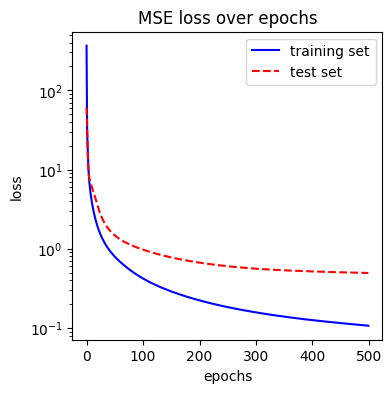

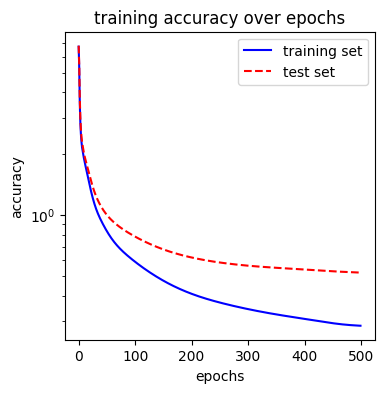

In [10]:
plot_over_epochs(y_values=net.training_losses, title='MSE loss over epochs', y_label='loss', y_legend='training set', y_prime_values=net.validation_losses, y_prime_legend='test set', yscale='log')
plot_over_epochs(y_values=net.training_evaluations, title='training accuracy over epochs', y_label='accuracy', y_legend='training set', y_prime_values=net.validation_evaluations, y_prime_legend='test set', yscale='log')

In [12]:
net.predict_and_evaluate(test_data, test_targets, Metrics.MEE.value)

0.5211710770951682